In this notebook we explore the independent subclustering the T-cell compartment of the Chen et al 2024 dataset and our SERPENTINE dataset. We are trying to assess whether there are patterns that emerge when clustering the dataset 

In [1]:
# basic python pa \=
import numpy as np
import pandas as pd
import os
import sys 

# plotting
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as stats

# singlecell packages
import scanpy as sc
import anndata
import scrublet
import harmonypy as hm

# other single cell packages
import muon as mu # multi-modal anndatas
import celltypist # automated label predictions
import scirpy # immune cell repertoire analysis

#sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load BigSur
bigsur_dir = '/home/groups/singlecell/smorabito/bin/BigSur/'
sys.path.append(bigsur_dir) 

from BigSur.feature_selection import mcfano_feature_selection as mcfano

In [3]:
# set the project directory 
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/')
data_dir = 'data/'
fig_dir = 'figures/'

In [4]:
# load the unprocessed dataset
cur_name = 'Tcells'
adata = sc.read_h5ad('{}Integrated_{}_unprocessed.h5ad'.format(data_dir, cur_name))


In [5]:
# split by primary and met:
adata_pri = adata[adata.obs.dataset == 'Chen2024'].copy()
adata_met = adata[adata.obs.dataset == 'SERPENTINE'].copy()

## Run the clustering for the primary tumor dataset

In [6]:
adata_pri.X = adata_pri.layers['counts'].copy()

In [7]:
# remove genes with very few counts:
sc.pp.filter_genes(adata_pri, min_cells=3)

In [8]:
# normalize
sc.pp.normalize_total(adata_pri)
sc.pp.log1p(adata_pri)

In [9]:
sc.pp.highly_variable_genes(
    adata_pri, flavor='seurat_v3',
    n_top_genes = 2000
)


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [10]:
sc.pp.regress_out(adata_pri, ['total_counts', 'pct_counts_mt'], n_jobs=16)
sc.pp.scale(adata_pri)

In [11]:
sc.tl.pca(adata_pri, svd_solver='arpack')

In [12]:
adata_pri.obs.columns

Index(['Replicate', 'Patient', 'Treatment', 'Tissue', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden',
       'AIFI_L1_prediction', 'AIFI_L1_score', 'AIFI_L2_prediction',
       'AIFI_L2_score', 'AIFI_L3_prediction', 'AIFI_L3_score',
       'Immune_All_Low_prediction', 'Immune_All_Low_score',
       'Immune_All_High_prediction', 'Immune_All_High_score', 'cell_type',
       'annotation', 'dataset', 'batch'],
      dtype='object')

In [14]:
sc.external.pp.bbknn(
    adata_pri, batch_key = 'Replicate'
)

In [15]:
adata_pri.obsm

AxisArrays with keys: AIFI_L1, AIFI_L2, AIFI_L3, Immune_All_High, Immune_All_Low, X_pca, X_umap

In [19]:
sc.tl.umap(
    adata_pri, min_dist=0.35, 
    method='umap',
    neighbors_key = 'neighbors'
)

In [20]:
sc.tl.leiden(
    adata_pri, 
    resolution=1,
    neighbors_key = 'neighbors'
)


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


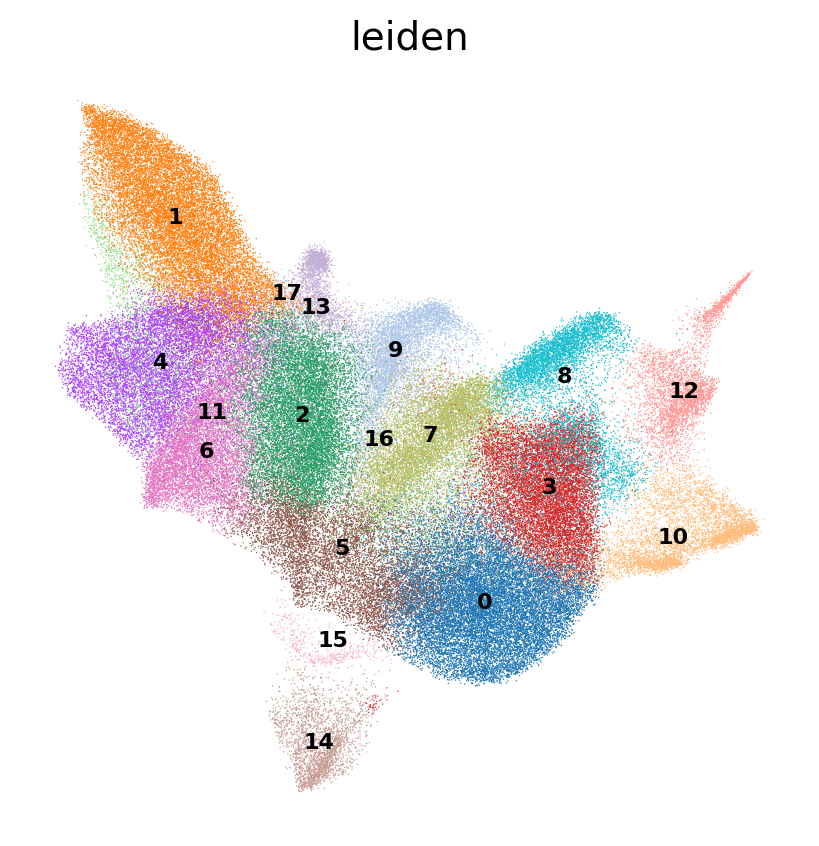

In [28]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata_pri,
    color = ['leiden'],
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
)

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


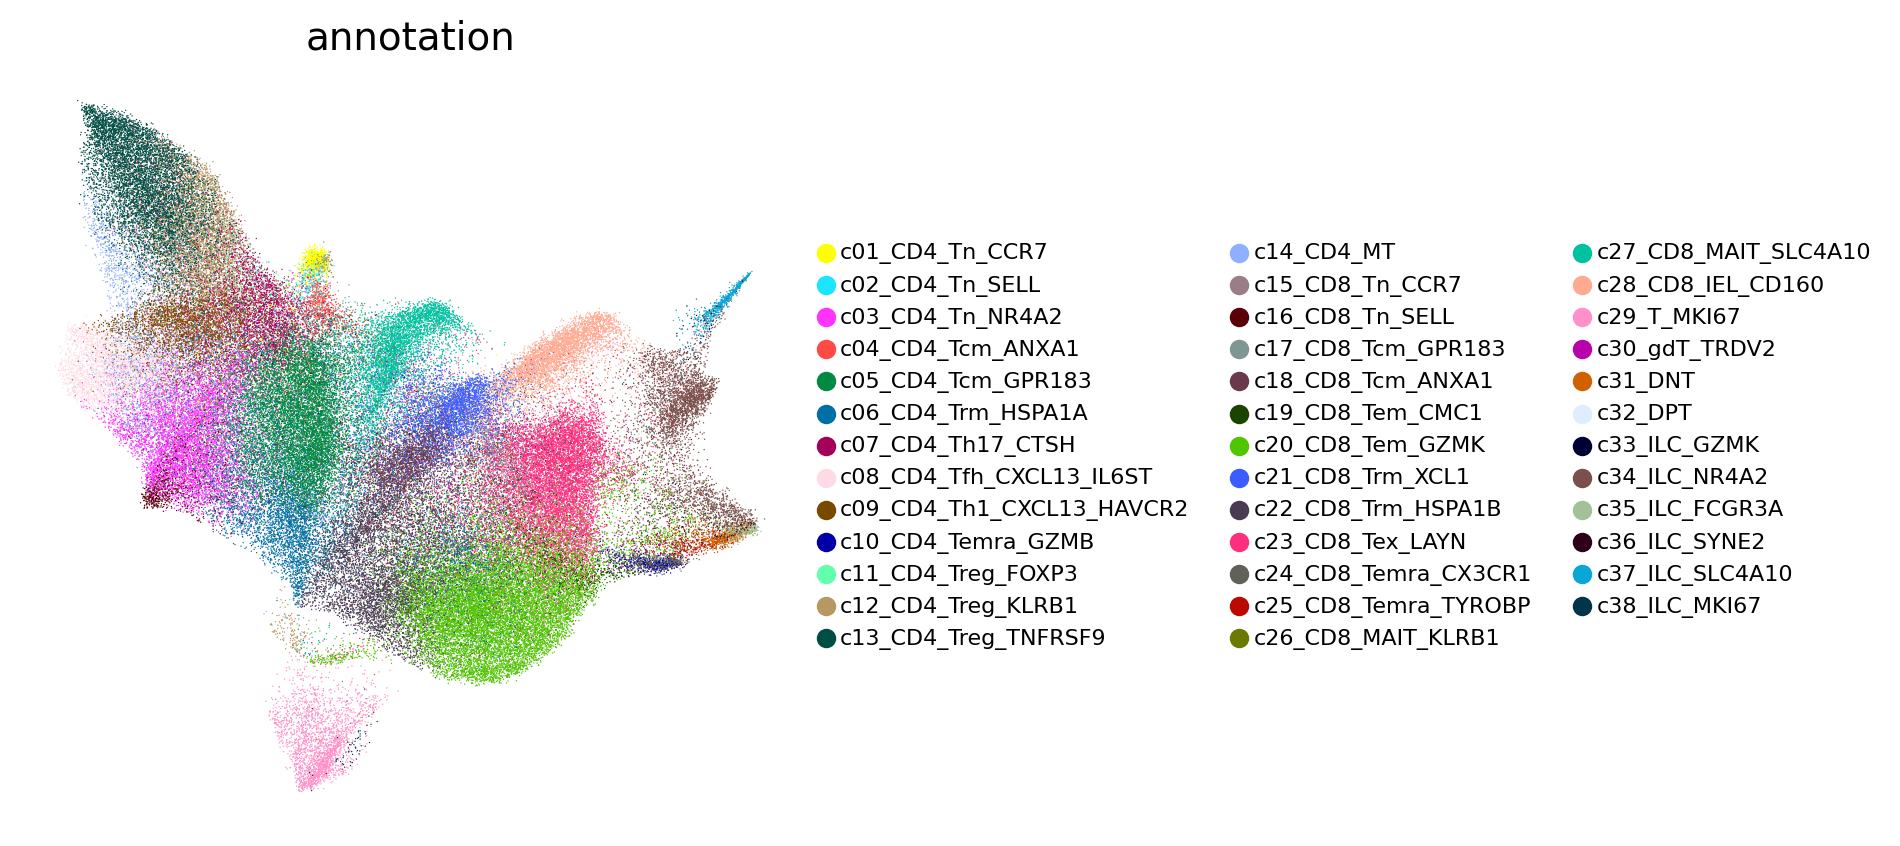

In [27]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata_pri,
    color = ['annotation'],
    legend_fontsize=8, 
    frameon = False,
)

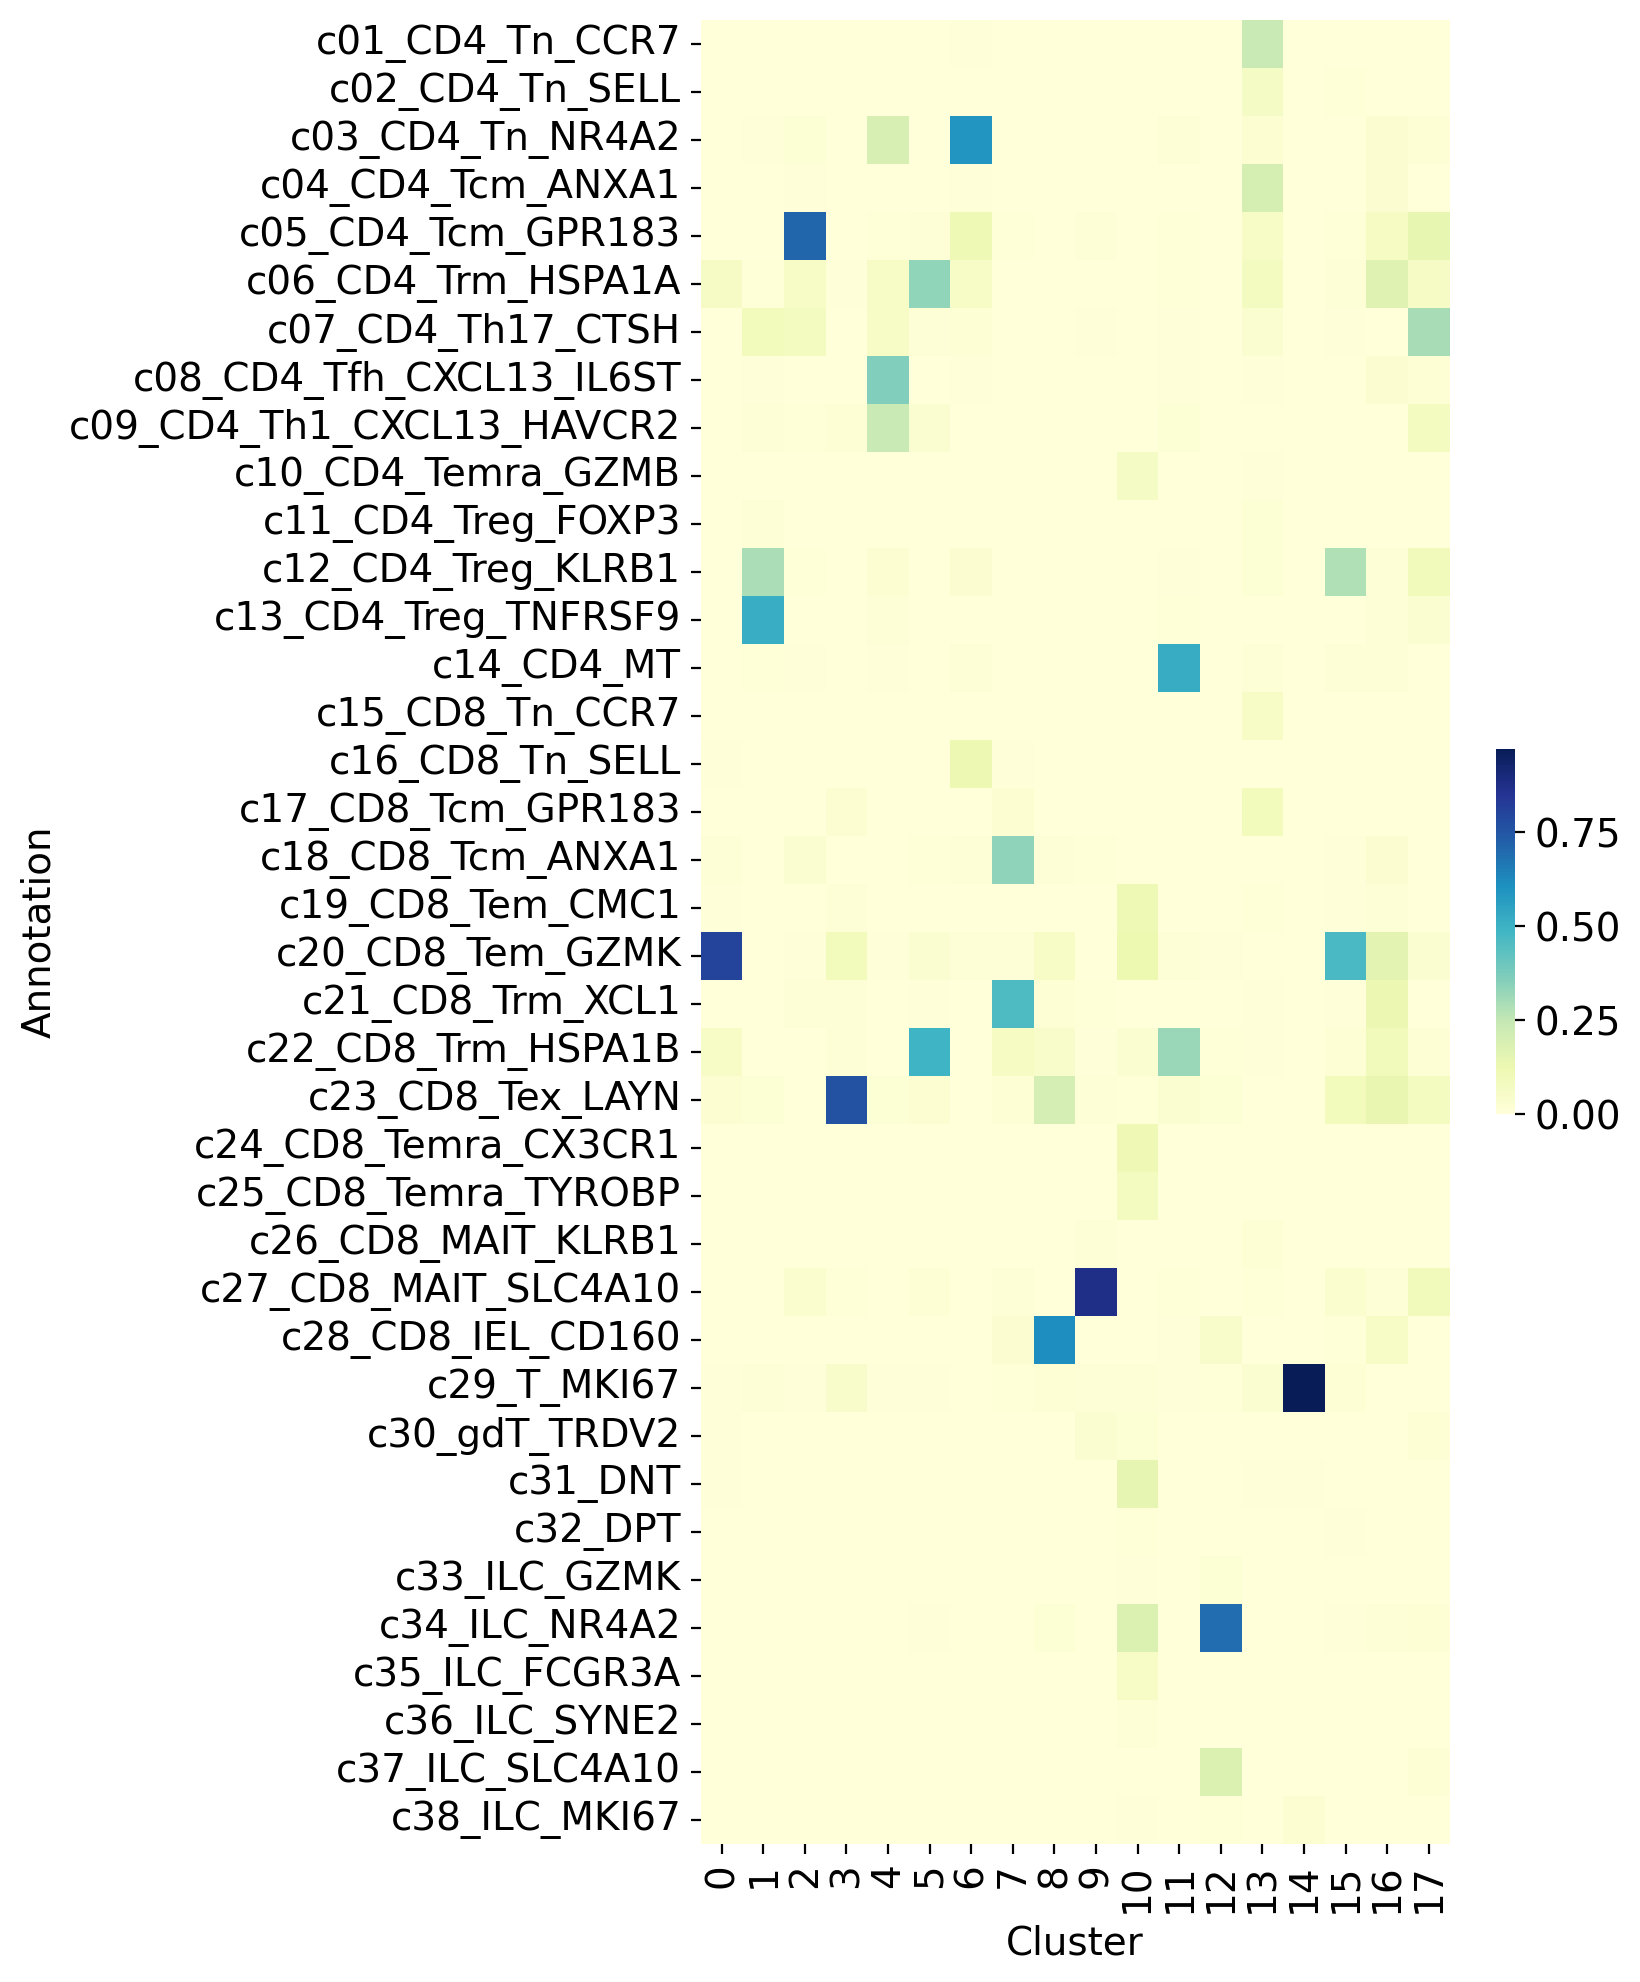

In [24]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(6,6), facecolor='white')

df = adata_pri.obs
sample_cluster_table = pd.crosstab(df['annotation'], df['leiden'])
normalized_table = sample_cluster_table.div(sample_cluster_table.sum(axis=0), axis=1)
normalized_table.head()

# Plot the normalized table as a heatmap
plt.figure(figsize=(6, 12))
sns.heatmap(
    normalized_table, 
    annot=False, cmap="YlGnBu", 
    cbar=True, fmt=".2f", cbar_kws={"shrink": 0.2}
)
plt.xlabel("Cluster")
plt.ylabel("Annotation")
plt.grid(None)
plt.show()